In [23]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt


In [22]:
pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.8/27.8 MB 2.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.3/47.3 kB 3.8 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 20.5 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [4]:
path = '/Users/arnavbhatnagar/Downloads/Uber Dataset/dataset.csv'
df = pd.read_csv(path)

In [5]:
# Perform the same initial cleaning as in the EDA
df['booking_datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], errors='coerce')
df.dropna(subset=['booking_datetime'], inplace=True)
print("Data loaded and initial cleaning complete.")

Data loaded and initial cleaning complete.


In [6]:
# --- 2. Feature Engineering and Target Variable Creation ---
print("--- Performing feature engineering... ---")

# Create the target variable: 1 for 'Completed', 0 for 'Not Completed'
df['target'] = df['Booking Status'].apply(lambda x: 1 if x == 'Completed' else 0)

# Extract time-based features from the datetime column
df['hour_of_day'] = df['booking_datetime'].dt.hour
df['day_of_week'] = df['booking_datetime'].dt.dayofweek # Monday=0, Sunday=6

# Select features for the model
# We exclude IDs, the original status column, datetime, and post-ride info like ratings/distance/value
features = [
    'Vehicle Type', 'Pickup Location', 'Drop Location', 'Payment Method',
    'hour_of_day', 'day_of_week'
]
X = df[features]
y = df['target']

print(f"Features selected for modeling: {features}")
print(f"Target variable 'target' created. Distribution:\n{y.value_counts(normalize=True)}")


--- Performing feature engineering... ---
Features selected for modeling: ['Vehicle Type', 'Pickup Location', 'Drop Location', 'Payment Method', 'hour_of_day', 'day_of_week']
Target variable 'target' created. Distribution:
target
1    0.62
0    0.38
Name: proportion, dtype: float64


In [7]:
# --- 3. Preprocessing ---
print("--- Setting up preprocessing pipeline... ---")

# Identify categorical and numerical features
categorical_features = ['Vehicle Type', 'Pickup Location', 'Drop Location', 'Payment Method', 'day_of_week']
numerical_features = ['hour_of_day']

# To handle high cardinality in location features, we'll group infrequent categories
for col in ['Pickup Location', 'Drop Location']:
    top_10 = X[col].value_counts().nlargest(10).index
    X[col] = X[col].where(X[col].isin(top_10), 'Other')

# Create a preprocessing pipeline
# This pipeline handles missing values and scales/encodes features automatically
preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='median'), numerical_features),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ]), categorical_features)
    ])


--- Setting up preprocessing pipeline... ---


/var/folders/zh/svd6hw515sqbb0b_8jcwb7vr0000gn/T/ipykernel_69496/2835088843.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = X[col].where(X[col].isin(top_10), 'Other')
/var/folders/zh/svd6hw515sqbb0b_8jcwb7vr0000gn/T/ipykernel_69496/2835088843.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = X[col].where(X[col].isin(top_10), 'Other')


In [8]:
# --- 4. Data Splitting ---
print("--- Splitting data into training and testing sets... ---")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Training set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")


--- Splitting data into training and testing sets... ---
Training set size: 120000 samples
Testing set size: 30000 samples


In [9]:
# --- 5. Model Training and Evaluation ---

# --- Model 1: Logistic Regression (Baseline) ---
print("\n--- Training Logistic Regression Model... ---")
lr_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', LogisticRegression(max_iter=1000, random_state=42))])

lr_pipeline.fit(X_train, y_train)
y_pred_lr = lr_pipeline.predict(X_test)

print("--- Logistic Regression Evaluation ---")
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("\nClassification Report:\n", classification_report(y_test, y_pred_lr))



--- Training Logistic Regression Model... ---
--- Logistic Regression Evaluation ---
Accuracy: 0.6914666666666667

Classification Report:
               precision    recall  f1-score   support

           0       0.56      0.91      0.69     11400
           1       0.91      0.56      0.69     18600

    accuracy                           0.69     30000
   macro avg       0.73      0.73      0.69     30000
weighted avg       0.78      0.69      0.69     30000



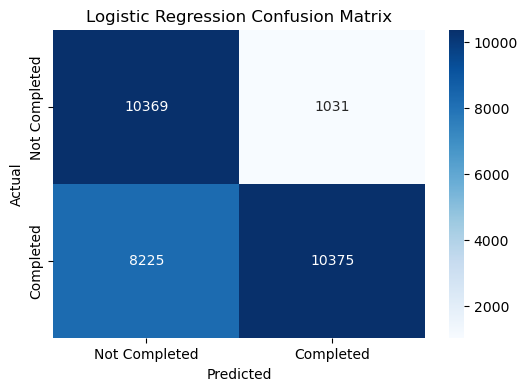

In [10]:
# Plot Confusion Matrix
cm_lr = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Completed', 'Completed'], yticklabels=['Not Completed', 'Completed'])
plt.title('Logistic Regression Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [15]:
# --- Model 2: XGBoost Classifier (Tuned and Optimized) ---
print("\n--- Setting up Tuned XGBoost Classifier... ---")

# Calculate scale_pos_weight for handling class imbalance
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]
print(f"Calculated scale_pos_weight for XGBoost: {scale_pos_weight:.2f}")

# Create the XGBoost pipeline
xgb_pipeline_tuned = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(use_label_encoder=False,
                                 eval_metric='logloss',
                                 scale_pos_weight=scale_pos_weight, # Address imbalance
                                 random_state=42))
])

# Define a smaller parameter grid for GridSearchCV to find the best settings
# This grid is intentionally small to ensure the script runs in a reasonable time.
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [5, 7],
    'classifier__learning_rate': [0.1],
    'classifier__colsample_bytree': [0.8]
}


--- Setting up Tuned XGBoost Classifier... ---
Calculated scale_pos_weight for XGBoost: 0.61


In [16]:
# Set up GridSearchCV to automate hyperparameter tuning
grid_search = GridSearchCV(estimator=xgb_pipeline_tuned,
                           param_grid=param_grid,
                           cv=3, # 3-fold cross-validation
                           scoring='accuracy',
                           verbose=2, # Shows progress
                           n_jobs=-1) # Use all available CPU cores

print("\n--- Training and Tuning XGBoost Classifier with GridSearchCV... ---")


--- Training and Tuning XGBoost Classifier with GridSearchCV... ---


In [17]:
grid_search.fit(X_train, y_train)

print(f"\nBest parameters found: {grid_search.best_params_}")

Fitting 3 folds for each of 4 candidates, totalling 12 fits


/Users/arnavbhatnagar/Desktop/College/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [23:33:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/arnavbhatnagar/Desktop/College/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [23:33:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/arnavbhatnagar/Desktop/College/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [23:33:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/arnavbhatnagar/Desktop/College/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [23:33:56] WARNING: /Users/


Best parameters found: {'classifier__colsample_bytree': 0.8, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 5, 'classifier__n_estimators': 100}


/Users/arnavbhatnagar/Desktop/College/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [23:33:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [18]:
best_xgb_model = grid_search.best_estimator_
y_pred_xgb = best_xgb_model.predict(X_test)

In [19]:
print("\n--- Tuned XGBoost Classifier Evaluation ---")
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("\nClassification Report:\n", classification_report(y_test, y_pred_xgb))


--- Tuned XGBoost Classifier Evaluation ---
Accuracy: 0.6918

Classification Report:
               precision    recall  f1-score   support

           0       0.56      0.91      0.69     11400
           1       0.91      0.56      0.69     18600

    accuracy                           0.69     30000
   macro avg       0.73      0.73      0.69     30000
weighted avg       0.78      0.69      0.69     30000



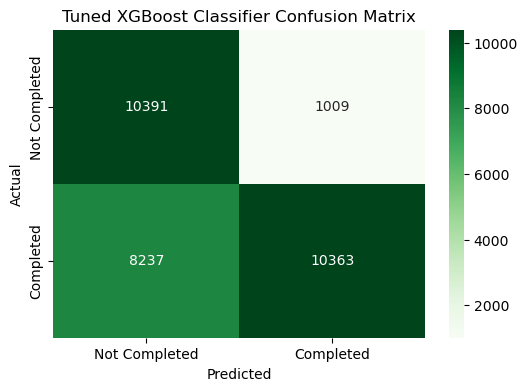


--- ML Modeling Complete ---


In [20]:
# Plot Confusion Matrix for the tuned model
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Greens', xticklabels=['Not Completed', 'Completed'], yticklabels=['Not Completed', 'Completed'])
plt.title('Tuned XGBoost Classifier Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

print("\n--- ML Modeling Complete ---")

In [ ]:
# Catboosting

In [35]:
X_train_cat = X_train.copy()
X_test_cat = X_test.copy()


In [37]:
for col in categorical_features:
    X_train_cat[col] = X_train_cat[col].astype('object')
    X_test_cat[col] = X_test_cat[col].astype('object')

In [38]:
for col in categorical_features:
    X_train_cat[col].fillna('Unknown', inplace=True)
    X_test_cat[col].fillna('Unknown', inplace=True)


/var/folders/zh/svd6hw515sqbb0b_8jcwb7vr0000gn/T/ipykernel_69496/53043019.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_train_cat[col].fillna('Unknown', inplace=True)
/var/folders/zh/svd6hw515sqbb0b_8jcwb7vr0000gn/T/ipykernel_69496/53043019.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always b

In [39]:
for col in numerical_features:
    median_val = X_train_cat[col].median()
    X_train_cat[col] = X_train_cat[col].fillna(median_val)
    X_test_cat[col] = X_test_cat[col].fillna(median_val)


In [40]:
cat_model = CatBoostClassifier(
    cat_features=categorical_features,
    auto_class_weights='Balanced', # Handles class imbalance
    random_state=42,
    verbose=0 # Suppress training output for a cleaner log
)


In [41]:
cat_model.fit(X_train_cat, y_train)
y_pred_cat = cat_model.predict(X_test_cat)

In [42]:
print("--- CatBoost Classifier Evaluation ---")
print("Accuracy:", accuracy_score(y_test, y_pred_cat))
print("\nClassification Report:\n", classification_report(y_test, y_pred_cat))

--- CatBoost Classifier Evaluation ---
Accuracy: 0.9379

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.84      0.91     11400
           1       0.91      1.00      0.95     18600

    accuracy                           0.94     30000
   macro avg       0.95      0.92      0.93     30000
weighted avg       0.94      0.94      0.94     30000



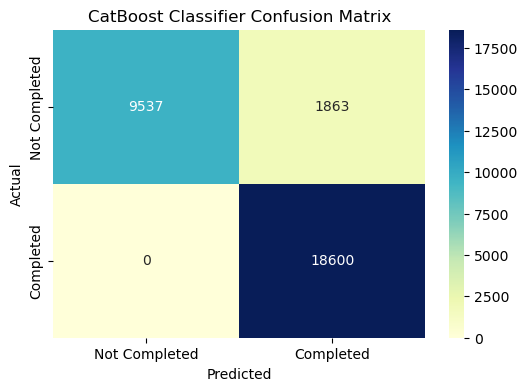


--- ML Modeling Complete ---


In [43]:
# Plot Confusion Matrix
cm_cat = confusion_matrix(y_test, y_pred_cat)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_cat, annot=True, fmt='d', cmap='YlGnBu', xticklabels=['Not Completed', 'Completed'], yticklabels=['Not Completed', 'Completed'])
plt.title('CatBoost Classifier Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

print("\n--- ML Modeling Complete ---")


In [45]:

# --- 6. Prediction on New/Hypothetical Data ---
print("\n--- Testing Model on Hypothetical Scenarios ---")

# Create a few example ride scenarios
new_rides = pd.DataFrame({
    'Vehicle Type': ['Auto', 'Go Sedan', 'eBike'],
    'Pickup Location': ['Karol Bagh', 'Nehru Place', 'Palam Vihar'],
    'Drop Location': ['Vishwavidyalaya', 'Aya Nagar', 'Jhilmil'],
    'Payment Method': ['UPI', 'Cash', 'Debit Card'],
    'hour_of_day': [14, 18, 12], # Afternoon, Evening, Mid-day
    'day_of_week': [5, 2, 5] # Saturday, Wednesday, Saturday
})

print("\nNew ride scenarios to predict:")
print(new_rides)

for col in categorical_features:
    new_rides[col] = new_rides[col].astype('object').fillna('Unknown')
for col in numerical_features:
    median_val = X_train_cat[col].median()
    new_rides[col] = new_rides[col].fillna(median_val)


# Use the trained CatBoost model to make predictions
predictions = cat_model.predict(new_rides)
prediction_proba = cat_model.predict_proba(new_rides)

# Display the results
print("\n--- Prediction Results ---")
for i, prediction in enumerate(predictions):
    status = "Completed" if prediction == 1 else "Not Completed"
    confidence = prediction_proba[i][prediction] * 100
    print(f"Scenario {i+1}: The model predicts the ride will be '{status}' with {confidence:.2f}% confidence.")


print("\n--- ML Modeling Complete ---")




--- Testing Model on Hypothetical Scenarios ---

New ride scenarios to predict:
  Vehicle Type Pickup Location    Drop Location Payment Method  hour_of_day  \
0         Auto      Karol Bagh  Vishwavidyalaya            UPI           14   
1     Go Sedan     Nehru Place        Aya Nagar           Cash           18   
2        eBike     Palam Vihar          Jhilmil     Debit Card           12   

   day_of_week  
0            5  
1            2  
2            5  

--- Prediction Results ---
Scenario 1: The model predicts the ride will be 'Completed' with 97.87% confidence.
Scenario 2: The model predicts the ride will be 'Completed' with 98.87% confidence.
Scenario 3: The model predicts the ride will be 'Completed' with 99.65% confidence.

--- ML Modeling Complete ---


/var/folders/zh/svd6hw515sqbb0b_8jcwb7vr0000gn/T/ipykernel_69496/3414631421.py:20: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  new_rides[col] = new_rides[col].astype('object').fillna('Unknown')
